### Goals 
The goal of this project is to apply some concepts & tools seen in the 3 parts of this course, this
project is organized into 3 parts :<br>
 Part 1 : Building Classical ML projects with respect to basic ML Coding best <br>practices<br>
 Part 2 : Integrate MLFlow to your project<br>
 Part 3 : Integrate ML Interpretability to your project<br>
### DataSet (Finance use case)
DataSet of Home Credit Risk Classification:<br>
https://www.kaggle.com/c/home-credit-default-risk/data<br>
you'll not use all the datasets available on Kaggle, only the main data set :<br>
application_train.csv<br>
application_test.csv<br>
You can also use a part of this dataset (an example is given for this Lab)

curl -X POST -H "Content-Type:application/json; format=pandas-split" --data '{"columns":["AMT_CREDIT","AMT_GOODS_PRICE","APARTMENTS_MODE","CODE_GENDER","DAYS_BIRTH","DAYS_ID_PUBLISH","DAYS_LAST_PHONE_CHANGE","DEF_30_CNT_SOCIAL_CIRCLE","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3","FLAG_DOCUMENT_3","FLAG_OWN_CAR","FLOORSMAX_MODE","LIVE_CITY_NOT_WORK_CITY","NAME_EDUCATION_TYPE","NONLIVINGAREA_MODE","OBS_30_CNT_SOCIAL_CIRCLE","REG_CITY_NOT_LIVE_CITY","REG_CITY_NOT_WORK_CITY"],"index":[0],"data":[[568800.0,450000.0,0.0672,"F",-19241,-812,-1740.0,0.0,0.7526144906,0.7896543511,0.1595195405,1,"N",0.125,0,"Higher education",0.0267437778,0.0,0,0]]}' http://localhost:1234/invocations

In [75]:
import pandas as pd
import numpy as np

from pathlib import Path
ROOT = Path('Project Application of BD.ipynb').resolve().parents[1]

# Some sklearn tools for preprocessing and building a pipeline.
# ColumnTransformer was introduced in 0.20 so make sure you have this version
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Algorithms, from the easiest to the hardest to intepret.r
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

In [151]:
app_train = pd.read_csv(ROOT/"data/raw/application_train.csv",nrows=5000)

# Feature selection

In [152]:
#https://www.kaggle.com/sz8416/6-ways-for-feature-selection
#intersection of 6 ways of feature selection
feature_selected =['TARGET','AMT_CREDIT','AMT_GOODS_PRICE','APARTMENTS_MODE','CODE_GENDER','DAYS_BIRTH','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE','DEF_30_CNT_SOCIAL_CIRCLE','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','FLAG_DOCUMENT_3','FLAG_OWN_CAR','FLOORSMAX_MODE','LIVE_CITY_NOT_WORK_CITY','NAME_EDUCATION_TYPE','NONLIVINGAREA_MODE','OBS_30_CNT_SOCIAL_CIRCLE','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY']
app_train=app_train[feature_selected]

In [153]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    11
int64       7
object      3
dtype: int64

In [154]:
app_train.columns.tolist()

['TARGET',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'APARTMENTS_MODE',
 'CODE_GENDER',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_DOCUMENT_3',
 'FLAG_OWN_CAR',
 'FLOORSMAX_MODE',
 'LIVE_CITY_NOT_WORK_CITY',
 'NAME_EDUCATION_TYPE',
 'NONLIVINGAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY']

In [155]:
len(app_train)

5000

In [156]:
# Some such as default would be binary features, but since
# they have a third class "unknown" we'll process them as non binary categorical
num_features=[]
cat_features=[]
for i in list(zip(app_train.columns,app_train.dtypes)):
    if (i[1] != 'object') :
        num_features.append(i[0])
    else : 
        cat_features.append(i[0])
num_features.remove("TARGET")

In [157]:
len(num_features),len(cat_features)

(17, 3)

In [158]:
app_train.isnull().sum()

TARGET                         0
AMT_CREDIT                     0
AMT_GOODS_PRICE                1
APARTMENTS_MODE             2487
CODE_GENDER                    0
DAYS_BIRTH                     0
DAYS_ID_PUBLISH                0
DAYS_LAST_PHONE_CHANGE         0
DEF_30_CNT_SOCIAL_CIRCLE      23
EXT_SOURCE_1                2827
EXT_SOURCE_2                  16
EXT_SOURCE_3                 975
FLAG_DOCUMENT_3                0
FLAG_OWN_CAR                   0
FLOORSMAX_MODE              2424
LIVE_CITY_NOT_WORK_CITY        0
NAME_EDUCATION_TYPE            0
NONLIVINGAREA_MODE          2677
OBS_30_CNT_SOCIAL_CIRCLE      23
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
dtype: int64

# Handle NaN values

In [159]:
#replace every nan of numerical features by the mean of this feature
for column in num_features:    
    app_train[column].fillna((app_train[column].mean()),inplace=True)
app_train.dropna(inplace=True)

In [160]:
app_train.isnull().sum()

TARGET                      0
AMT_CREDIT                  0
AMT_GOODS_PRICE             0
APARTMENTS_MODE             0
CODE_GENDER                 0
DAYS_BIRTH                  0
DAYS_ID_PUBLISH             0
DAYS_LAST_PHONE_CHANGE      0
DEF_30_CNT_SOCIAL_CIRCLE    0
EXT_SOURCE_1                0
EXT_SOURCE_2                0
EXT_SOURCE_3                0
FLAG_DOCUMENT_3             0
FLAG_OWN_CAR                0
FLOORSMAX_MODE              0
LIVE_CITY_NOT_WORK_CITY     0
NAME_EDUCATION_TYPE         0
NONLIVINGAREA_MODE          0
OBS_30_CNT_SOCIAL_CIRCLE    0
REG_CITY_NOT_LIVE_CITY      0
REG_CITY_NOT_WORK_CITY      0
dtype: int64

# Machine Learning

In [87]:
# Get X, y
y = app_train["TARGET"]
X = app_train.drop("TARGET", axis=1)

In [88]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features),
 ("categorical", OneHotEncoder(sparse=False, handle_unknown='ignore'),
 cat_features)])

In [89]:
# XGBoost
xgb_model = Pipeline([("preprocessor", preprocessor),
 # Add a scale_pos_weight to make it balanced
 ("model", XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))])

# Random Forest
rf_model = Pipeline([("preprocessor", preprocessor),
 ("model", RandomForestClassifier(class_weight="balanced", n_estimators=100))])

#GradientBoostingClassifier
gb_model = Pipeline([("preprocessor", preprocessor),
 ("model", GradientBoostingClassifier())])

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

# XGBOOST

In [106]:
gs = GridSearchCV(xgb_model, {"model__max_depth": [5, 10],
 "model__min_child_weight": [5, 10],
 "model__n_estimators": [25]},
 n_jobs=-1, cv=5, scoring="f1")
gs.fit(X_train, y_train)

print(gs.best_params_)
print(gs.best_score_)

xgb_model.set_params(**gs.best_params_)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred)

{'model__max_depth': 10, 'model__min_child_weight': 5, 'model__n_estimators': 25}
0.06816423833214877


0.92

In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1384
           1       0.33      0.03      0.06       116

    accuracy                           0.92      1500
   macro avg       0.63      0.51      0.51      1500
weighted avg       0.88      0.92      0.89      1500



In [108]:
confusion_matrix(y_test, y_pred)

array([[1376,    8],
       [ 112,    4]], dtype=int64)

# RANDOM FOREST

In [109]:
gs = GridSearchCV(rf_model, {"model__max_depth": [10, 15],
 "model__min_samples_split": [5, 10]},
 n_jobs=-1, cv=5, scoring="f1")
gs.fit(X_train, y_train)

print(gs.best_params_)
print(gs.best_score_)

rf_model.set_params(**gs.best_params_)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)

{'model__max_depth': 10, 'model__min_samples_split': 10}
0.24616005874012803


0.8806666666666667

In [110]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1384
           1       0.22      0.21      0.21       116

    accuracy                           0.88      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.88      0.88      0.88      1500



In [111]:
confusion_matrix(y_test, y_pred)

array([[1297,   87],
       [  92,   24]], dtype=int64)

# GRADIENT BOOSTING

In [112]:
gs = GridSearchCV(gb_model, {"model__max_depth": [10, 15],
 "model__min_samples_split": [5, 10]},
 n_jobs=-1, cv=5, scoring="f1")
gs.fit(X_train, y_train)

print(gs.best_params_)
print(gs.best_score_)

gb_model.set_params(**gs.best_params_)
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)
accuracy_score(y_test, y_pred)

{'model__max_depth': 10, 'model__min_samples_split': 5}
0.11883184729290777


0.912

In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1384
           1       0.33      0.03      0.06       116

    accuracy                           0.92      1500
   macro avg       0.63      0.51      0.51      1500
weighted avg       0.88      0.92      0.89      1500



In [33]:
confusion_matrix(y_test, y_pred)

array([[1366,   18],
       [ 111,    5]], dtype=int64)

# Predictions with xgb model on application_test

In [137]:
app_test = pd.read_csv(ROOT/"data/raw/application_test.csv",nrows=5000)

In [138]:
feature_selected =['AMT_CREDIT','AMT_GOODS_PRICE','APARTMENTS_MODE','CODE_GENDER','DAYS_BIRTH','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE','DEF_30_CNT_SOCIAL_CIRCLE','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','FLAG_DOCUMENT_3','FLAG_OWN_CAR','FLOORSMAX_MODE','LIVE_CITY_NOT_WORK_CITY','NAME_EDUCATION_TYPE','NONLIVINGAREA_MODE','OBS_30_CNT_SOCIAL_CIRCLE','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY']
app_test=app_test[feature_selected]

In [139]:
predictions = xgb_model.predict(app_test)

In [142]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# XAI

In [116]:
import shap
# Need to load JS vis in the notebook
shap.initjs() 

In [117]:
explainer = shap.TreeExplainer(xgb_model.named_steps["model"])

In [118]:
observations = xgb_model.named_steps["preprocessor"].transform(X_train.sample(796, random_state=42))
shap_values = explainer.shap_values(observations)

In [119]:
i = 0
shap.force_plot(explainer.expected_value, shap_values[i],
 features=observations[i], feature_names=all_features)

In [120]:
shap.force_plot(explainer.expected_value, shap_values,
 features=observations, feature_names=all_features)

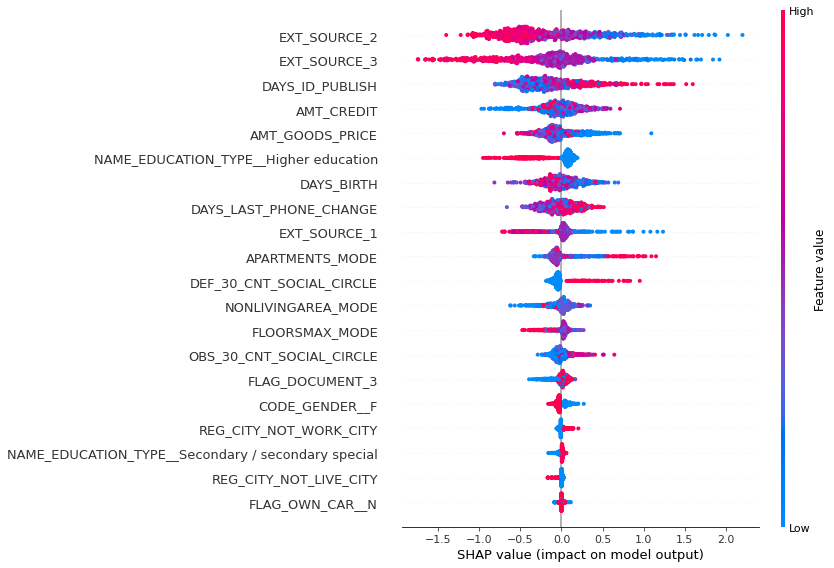

In [121]:
shap.summary_plot(shap_values, features=observations, feature_names=all_features)